# Coarse-graining example

In [6]:
import dedalus.public as d3
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr

from modules import coarse_graining


In [2]:
base_path = '/srv/ccrc/AtmSS/z5310829/honours_project/'
fig_path = base_path + 'figures/thesis/04_tendencies/'
data_path = base_path + 'data/training/2048x256_t/'


In [5]:
data = xr.open_mfdataset(data_path + '*.nc').isel(t=-1).compute()


In [13]:
coords = d3.CartesianCoordinates('x', 'z')
dist = d3.Distributor(coords, dtype=np.float64)
xbasis = d3.RealFourier(coords['x'], size=256, bounds=(0, 8))
zbasis = d3.ChebyshevT(coords['z'], size=64, bounds=(0, 1))
x_new = dist.local_grid(xbasis).squeeze()
z_new = dist.local_grid(zbasis).squeeze()


In [14]:
conservative_regridder = coarse_graining.ConservativeRegridder(
    source=data, target={'x': x_new, 'z': z_new},
    limits={'z': (0, 1)}, periods={'x': 8},
)
data_regridded = conservative_regridder(data).transpose('x', 'z')


In [15]:
coarse_grainer = coarse_graining.CoarseGrainer(aspect=8, Nx=2048, Nz=256)
data_coarse_grained = coarse_grainer.run(
    data.u.data, data.w.data, data.theta.data,
    time=1e-3, dt=2e-4, to_shape=(256, 64),
)


2023-10-27 11:59:57,751 subsystems 0/1 INFO :: Building subproblem matrices 1/1024 (~0%) Elapsed: 0s, Remaining: 4m 41s, Rate: 3.6e+00/s
2023-10-27 12:00:07,480 subsystems 0/1 INFO :: Building subproblem matrices 94/1024 (~9%) Elapsed: 10s, Remaining: 1m 39s, Rate: 9.4e+00/s
2023-10-27 12:00:08,408 subsystems 0/1 INFO :: Building subproblem matrices 103/1024 (~10%) Elapsed: 11s, Remaining: 1m 38s, Rate: 9.4e+00/s
2023-10-27 12:00:17,529 subsystems 0/1 INFO :: Building subproblem matrices 191/1024 (~19%) Elapsed: 20s, Remaining: 1m 27s, Rate: 9.5e+00/s
2023-10-27 12:00:19,061 subsystems 0/1 INFO :: Building subproblem matrices 206/1024 (~20%) Elapsed: 22s, Remaining: 1m 26s, Rate: 9.5e+00/s
2023-10-27 12:00:27,556 subsystems 0/1 INFO :: Building subproblem matrices 288/1024 (~28%) Elapsed: 30s, Remaining: 1m 17s, Rate: 9.6e+00/s
2023-10-27 12:00:29,707 subsystems 0/1 INFO :: Building subproblem matrices 309/1024 (~30%) Elapsed: 32s, Remaining: 1m 15s, Rate: 9.6e+00/s
2023-10-27 12:00:37

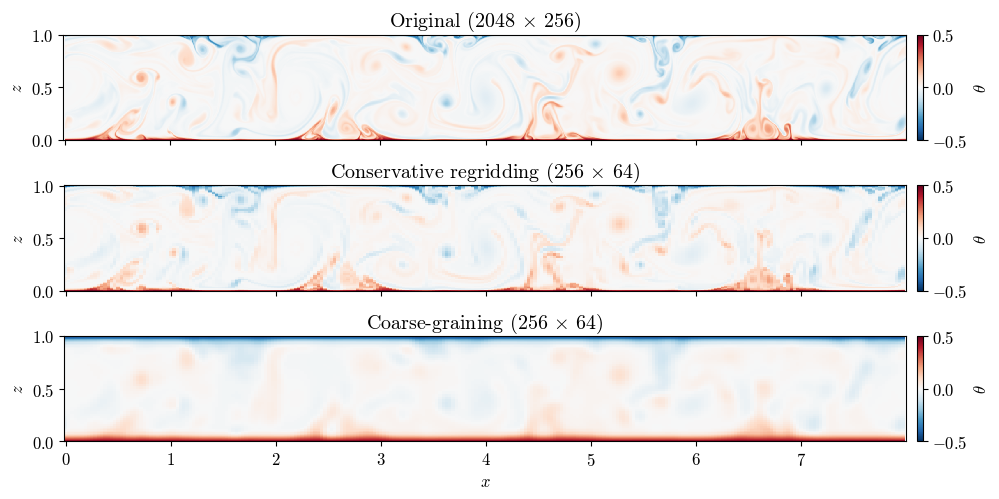

In [24]:
fig, axes = plt.subplots(3, 1, figsize=(12, 5), sharex=True)

mesh = axes[0].pcolormesh(
    data.x, data.z, data.theta.T, cmap='RdBu_r', rasterized=True
)
mesh.set_clim(-0.5, 0.5)
fig.colorbar(mesh, ax=axes[0], pad=0.01, label='$\\theta$')
axes[0].set(
    ylabel='$z$', title='Original (2048 $\\times$ 256)', aspect='equal'
)

mesh = axes[1].pcolormesh(
    x_new, z_new, data_regridded.theta.T, cmap='RdBu_r', rasterized=True
)
mesh.set_clim(-0.5, 0.5)
fig.colorbar(mesh, ax=axes[1], pad=0.01, label='$\\theta$')
axes[1].set(
    ylabel='$z$', title='Conservative regridding (256 $\\times$ 64)',
    aspect='equal',
)

mesh = axes[2].pcolormesh(
    x_new, z_new, data_coarse_grained[2].T, cmap='RdBu_r', rasterized=True
)
mesh.set_clim(-0.5, 0.5)
fig.colorbar(mesh, ax=axes[2], pad=0.01, label='$\\theta$')
axes[2].set(
    xlabel='$x$', ylabel='$z$', aspect='equal',
    title='Coarse-graining (256 $\\times$ 64)',
)

fig.tight_layout()
fig.savefig(fig_path + 'coarse_graining_example.pdf')
